In [1]:
import numpy as np
import embedded_voting as ev
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [2]:
ratings_training = np.loadtxt("ratings_base_case_training_normal.csv",dtype=float,delimiter=",")
ratings_testing = np.loadtxt("ratings_base_case_testing_normal.csv",dtype=float,delimiter=",")

In [3]:
def f_max(ratings_v, history_mean, history_std):
    return np.maximum(0, (ratings_v - history_mean) / history_std)

def f_renorm(ratings_v, history_mean, history_std):
    return (ratings_v - history_mean) / history_std

# Base case

In [11]:
n_candidates = 20
n_trys = 10000
max_candidates = 50

list_agg = [ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalProduct(), f=f_max), name="ApprovalProduct"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalSum(), f=f_max), name="ApprovalSum"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalRandom(), f=f_max), name="ApprovalRandom"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleSumRatings(), f=f_renorm), name="Sum"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE-t", default_train=False, default_add=False),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash-t", default_train=False,default_add=False)]

rules_names = [agg.name for agg in list_agg]

In [14]:
#sigma**2 = (k*sigma_g**2 + sigma_i**2)


oracle_vec = [1/(20*100 + 4)]*20 + [1/(1*100+4)]*4

In [12]:
n_voters = 24
results_algo = np.zeros((n_trys))


for index_try in tqdm(range(n_trys)):
    truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
    ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
    i = 20
    for agg in list_agg[:-2]:
        agg.reset()
        

    ## training
    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_


    w = np.argmax(ratings_candidates[0])
    results_algo[index_try] += welfare[w]

100%|██████████| 10000/10000 [00:01<00:00, 6247.68it/s]


In [7]:
results_algo.mean()

0.7188875360732854

In [8]:
for alpha in [i*.1 for i in range(11)]:
    print(np.round(alpha,1), 0.6548692105730108)

0.0 0.6548692105730108
0.1 0.6548692105730108
0.2 0.6548692105730108
0.3 0.6548692105730108
0.4 0.6548692105730108
0.5 0.6548692105730108
0.6 0.6548692105730108
0.7 0.6548692105730108
0.8 0.6548692105730108
0.9 0.6548692105730108
1.0 0.6548692105730108


In [15]:
n_agg = len(list_agg)
n_voters = 24
results_exp = np.zeros((n_agg + 3, n_trys))
accuracy_exp = np.zeros((n_agg + 3, n_trys))
results_algo = np.zeros((n_voters, n_trys))
accuracy_algo = np.zeros((n_voters, n_trys))

training = ratings_training[11:11+n_voters]
for i in range(2):
    _ = list_agg[-(i+1)](training).winner_
    list_agg[-(i+1)].train()


for index_try in tqdm(range(n_trys)):
    truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
    ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
    i = 20
    for agg in list_agg[:-2]:
        agg.reset()
        

    ## training
    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
    # getting the results

    for k,agg in enumerate(list_agg):
        w = agg(ratings_candidates).winner_
        results_exp[k][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_exp[k][index_try] += 1
            
    w = np.random.randint(n_candidates)
    results_exp[n_agg][index_try] += welfare[w]
    if w == np.argmax(welfare):
        accuracy_exp[n_agg][index_try] += 1
        
    for j in range(n_voters):
        w = np.argmax(ratings_candidates[j])
        results_algo[j][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_algo[j][index_try] += 1
            
        
    taboracle = ratings_candidates.T.dot(oracle_vec)#np.mean(ratings_candidates[:20], 0) + np.sum(ratings_candidates[20:], 0)
    w = np.argmax(taboracle)
    results_exp[n_agg+1][index_try] += welfare[w]
    if w == np.argmax(welfare):
        accuracy_exp[n_agg+1][index_try] += 1


100%|██████████| 10000/10000 [03:20<00:00, 49.97it/s]


In [10]:
results_exp.mean(1)

array([0.84698609, 0.8214542 , 0.82014176, 0.80008702, 0.75045288,
       0.61924595, 0.86044912, 0.8582426 , 0.49626204, 0.86391845,
       0.        ])

In [ ]:
# 1. Effet constnate nash
# 0, 1, 2, 3
# Untrained: 0.755, 0.7735, [0.775], 0.773,
# Trained : 0.776, 0.783, [0.792], 0793
# 2. Effet constante autres
# approval 0, 1, 2
# 0.75, 0.73, 0.70 (-1 => 0.69)
# sum 0, 1, 2
# 0.687, 0.697, 0.691
# MLe 0,1,2,3,4,5 (max à 3)
# 0.785, 0.789, 0.791, 0.793,0.793, 0.793
# 3. Effet training approval, sum
# Approval => améliore pas particulierement
# Sum => Pareil
# Sum
# 4. Effet cap sum
# Change rien pour approval
# Pour sum ça améliore de capper (?)

In [16]:
np.savetxt("results_base_case_normal_b.csv", np.concatenate([results_exp[:n_agg+2], results_algo]), delimiter=",")
np.savetxt("accuracy_base_case_normal_b.csv", np.concatenate([accuracy_exp[:n_agg+2], accuracy_algo]), delimiter=",")

In [4]:

list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, 2))]
rules_names = [agg.name for agg in list_agg]

n_agg = len(list_agg)
n_voters = 24
results_exp = np.zeros((n_agg, n_trys))
accuracy_exp = np.zeros((n_agg , n_trys))

for index_try in tqdm(range(n_trys)):
    truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
    ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
    for agg in list_agg:
        agg.reset()
        
    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
    # getting the results

    for k,agg in enumerate(list_agg):
        w = agg(ratings_candidates).winner_
        results_exp[k][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_exp[k][index_try] += 1

100%|██████████| 10000/10000 [00:15<00:00, 658.82it/s]


In [7]:
results_exp.mean(1)

array([0.79555364])

In [8]:
np.savetxt("results_base_case_groupaware.csv", results_exp, delimiter=",")
np.savetxt("accuracy_base_case_groupaware.csv", accuracy_exp, delimiter=",")

In [25]:
res = np.loadtxt("results_base_case_4.csv", dtype=float,delimiter=",")

In [26]:
n_agg = 8

In [27]:
algos_res = res[:n_agg+2].mean(1)
best_algo = res[n_agg+2:].mean(1).max()
algos_res = np.concatenate([algos_res, [best_algo]])
algos_name = ["FastNash", "AppProd", "AppSum", "AppRand", "Sum", "MLE", "MLE-t", "FastNash-t", "Random", "Oracle", "BestAlgo"]

In [28]:
colors = {"FastNash":"#de302a", "AppProd":"#32e62c", "AppSum":"#45ba41", "AppRand":"#6ab068",
         "Sum":"#dee046", "MLE":"#2488ed", "MLE-t":"#4540cf", "FastNash-t":"#a83d3d","Random":"#707070",
          "Oracle":"#707070", "BestAlgo":"#707070"}

In [29]:
algos_res

array([0.78307467, 0.75403951, 0.75328892, 0.7409754 , 0.68702186,
       0.51545136, 0.78490166, 0.7923564 , 0.49537776, 0.79555364,
       0.65789297])

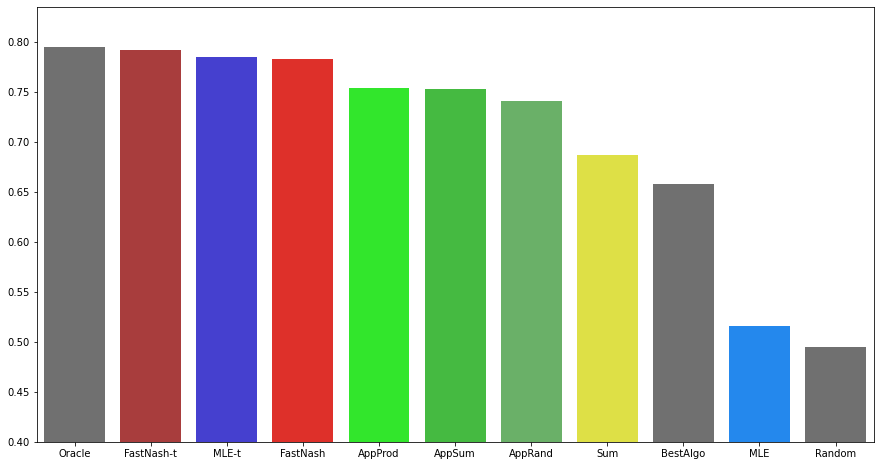

In [30]:
order = algos_res.argsort()[::-1]
plt.figure(figsize=(15,8))
for i in range(len(order)):
    plt.bar(i, algos_res[order[i]],color=colors[algos_name[order[i]]])
    
plt.xticks(range(len(order)), [algos_name[i] for i in order])
plt.xlim(-0.5,len(order)-0.5)
plt.ylim(0.4)
    
plt.show()

In [31]:
order

array([ 9,  7,  6,  0,  1,  2,  3,  4, 10,  5,  8], dtype=int64)

In [37]:
order_next = [5,4,0,1,2,3]

# Evolution with training

In [12]:

list_agg = [ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE-t"),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash-t")]

In [13]:
n_agg = len(list_agg)
list_train = [0,20,40,60,100,140,300,620,1260]
l_train = len(list_train)
max_candidates = 50
n_candidates = 20
results_exp = np.zeros((n_agg, l_train))

for i in range(l_train):
    size_train = list_train[i]
    for agg in list_agg:
        agg.reset()
    if (size_train > 0):
        training = ratings_training[11:35,:size_train]
        _ = list_agg[0](training).winner_
        list_agg[0].train()
        _ = list_agg[1](training).winner_
        list_agg[1].train()
    
    for index_try in tqdm(range(n_trys)):
        
        
    
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]


        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            agg2 = copy.copy(agg)
            w = agg2(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_4 = results_exp

100%|██████████| 10000/10000 [22:38<00:00,  7.36it/s]


In [14]:
np.savetxt("results_expe_4_normal.csv", results_exp_4/n_trys, delimiter=",")

# Evolution with groupe homogéne

In [17]:
n_trys = 10000

list_agg = [ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalProduct(), f=f_max), name="ApprovalProduct"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleSumRatings(), f=f_renorm), name="Sum"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE-t", default_train=False, default_add=False),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash-t", default_train=False,default_add=False)]

rules_names = [agg.name for agg in list_agg]

In [16]:
n_agg = len(list_agg)
list_size = [1] + list(np.arange(2,31,2))
l_size = len(list_size)
max_candidates = 50
n_candidates = 20
results_exp = np.zeros((n_agg, l_size))

res2 = np.zeros((n_agg, n_trys))
for i in range(l_size):
    size_group = list_size[i]
    for agg in list_agg[-2:]:
        agg.reset()
    training = ratings_training[31-size_group:35]
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[31-size_group:35,max_candidates*index_try:max_candidates*index_try+n_candidates]

        for agg in list_agg[:-2]:
            agg.reset()
#         for agg in list_agg:
#             agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_1 = results_exp

100%|██████████| 10000/10000 [03:35<00:00, 46.43it/s]


In [17]:
np.savetxt("results_expe_1_normal.csv", results_exp_1/n_trys, delimiter=",")

In [10]:

rules_names = [agg.name for agg in list_agg]

n_agg = len(list_agg)
list_size = [1] + list(np.arange(2,31,2))
l_size = len(list_size)
max_candidates = 50
n_candidates = 20
results_exp = np.zeros((2, l_size))


for i in range(l_size):
    size_group = list_size[i]
    #print(size_group)
    algo_welfare = np.zeros(size_group+4)
    
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([size_group,1,1,1,1], np.eye(5), 10, 2))]
    for index_try in tqdm(range(n_trys)):
    
        for agg in list_agg:
            agg.reset()
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[31-size_group:35,max_candidates*index_try:max_candidates*index_try+n_candidates]

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
        
        
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
    
    results_exp[1][i] = np.max(algo_welfare)


100%|██████████| 10000/10000 [00:19<00:00, 500.14it/s]


In [11]:
np.savetxt("results_expe_1_bounds.csv", results_exp/n_trys, delimiter=",")

# Evolution with number of groupes

In [18]:
n_agg = len(list_agg)
list_groups = [0,1] + list(np.arange(2,21,2))
l_groups = len(list_groups)
max_candidates = 50
results_exp = np.zeros((n_agg, l_size))


for i in range(l_groups):
    n_group = list_groups[i]
    for agg in list_agg[-2:]:
        agg.reset()
    training = ratings_training[11:31+n_group]
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[11:31+n_group,max_candidates*index_try:max_candidates*index_try+n_candidates]

        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_2 = results_exp

100%|██████████| 10000/10000 [03:50<00:00, 43.40it/s]


In [19]:
np.savetxt("results_expe_2_normal.csv", results_exp_2[:,:12]/n_trys, delimiter=",")

In [13]:
n_agg = len(list_agg)
list_groups = [0,1] + list(np.arange(2,21,2))
l_groups = len(list_groups)
max_candidates = 50
results_exp = np.zeros((2, l_groups))


for i in range(l_groups):
    n_group = list_groups[i]
    
    algo_welfare = np.zeros(n_group+20)
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20]+[1]*n_group, np.eye(1+n_group), 10, 2))]
    for index_try in tqdm(range(n_trys)):
    
        for agg in list_agg:
            agg.reset()
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[11:31+n_group,max_candidates*index_try:max_candidates*index_try+n_candidates]

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
        
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
    
    results_exp[1][i] = np.max(algo_welfare)
            

100%|██████████| 10000/10000 [00:29<00:00, 339.53it/s]


In [14]:
np.savetxt("results_expe_2_bounds.csv", results_exp/n_trys, delimiter=",")

# Evolution nombre de candidats

In [4]:
algos_name = ["GA", "FastNash", "AppProd", "Sum", "MLE", "MLE-t", "FastNash-t"]

In [5]:

n_trys = 10000

list_agg = [#ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, 2)),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalProduct(), f=f_max), name="ApprovalProduct"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleSumRatings(), f=f_renorm), name="Sum"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE-t", default_train=False, default_add=False),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash-t", default_train=False,default_add=False)
            ]

rules_names = [agg.name for agg in list_agg]

In [21]:
n_agg = len(list_agg)
list_candidates = [2,3,4,5,6,7,8,9] + list(np.arange(10,51,5))
l_cand = len(list_candidates)
max_candidates = 50
n_voters = 10
results_algo = np.zeros((l_cand))


#19, 8, 20



weights = np.zeros((l_cand, n_voters))
welf = np.zeros(l_cand)
for index_try in tqdm(range(1000)):
    for i in range(l_cand):
        n_candidates = list_candidates[i]
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[26:26+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
#         print("ratings",ratings_candidates)

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        list_agg[4].reset()

        weights[i] += np.linalg.pinv(list_agg[4](ratings_candidates).embeddings_).sum(axis=0)
        w = list_agg[4](ratings_candidates).winner_
        welf[i] += (welfare[w])

weights /= 1000
welf /= 1000
    

    
    

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s]


2


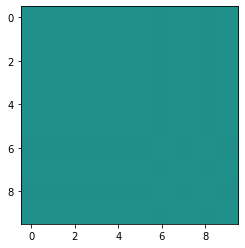

3


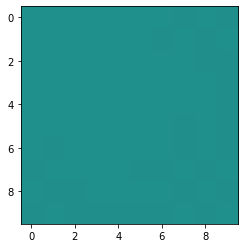

4


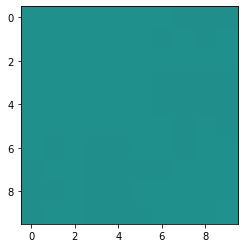

5


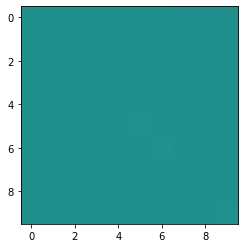

6


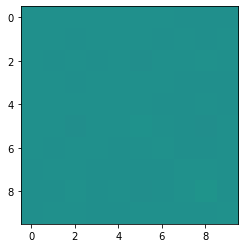

7


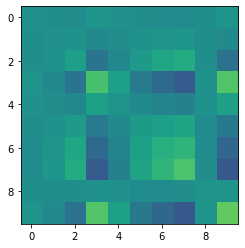

8


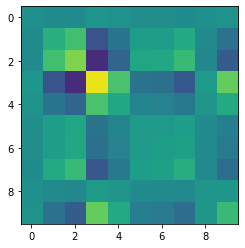

9


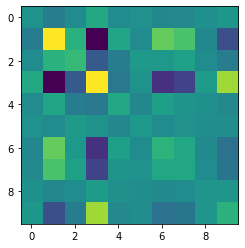

10


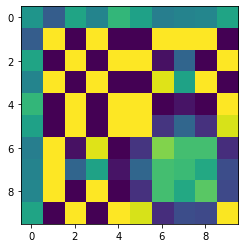

15


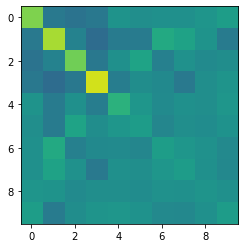

20


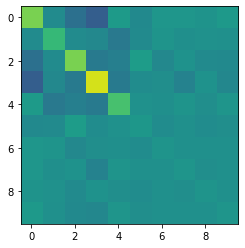

25


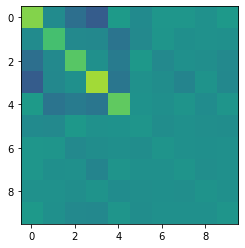

30


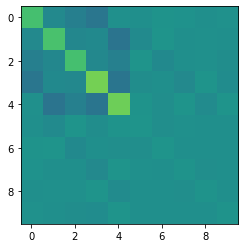

35


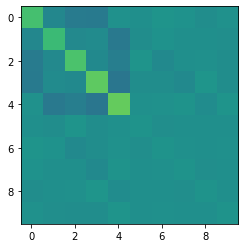

40


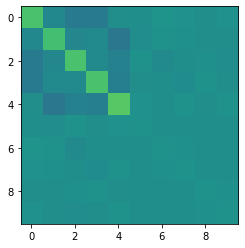

45


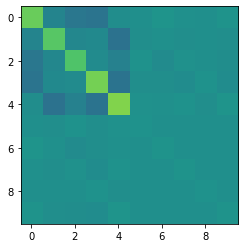

50


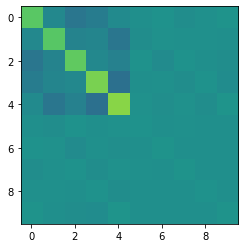

In [26]:
list_candidates = [2,3,4,5,6,7,8,9] + list(np.arange(10,51,5))
l_cand = len(list_candidates)
max_candidates = 50
n_voters = 10
results_algo = np.zeros((l_cand))


#19, 8, 20

index_try=19


weights = np.zeros((l_cand, n_voters))
welf = np.zeros(l_cand)
for i in range(l_cand):
    n_candidates = list_candidates[i]
    truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
    ratings_candidates = ratings_testing[26:26+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
#         print("ratings",ratings_candidates)

    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
    list_agg[4].reset()

    print(list_candidates[i])
#     plt.imshow(list_agg[4](ratings_candidates).embeddings_)
    plt.imshow(np.linalg.pinv(list_agg[4](ratings_candidates).embeddings_), vmin=-50,vmax=50)
    plt.show()
    weights[i] += np.linalg.pinv(list_agg[4](ratings_candidates).embeddings_).sum(axis=0)
    w = list_agg[4](ratings_candidates).winner_
    welf[i] += (welfare[w])


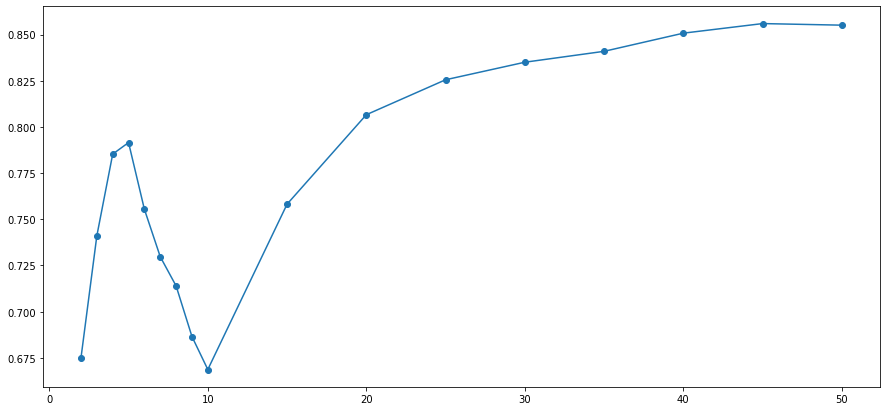

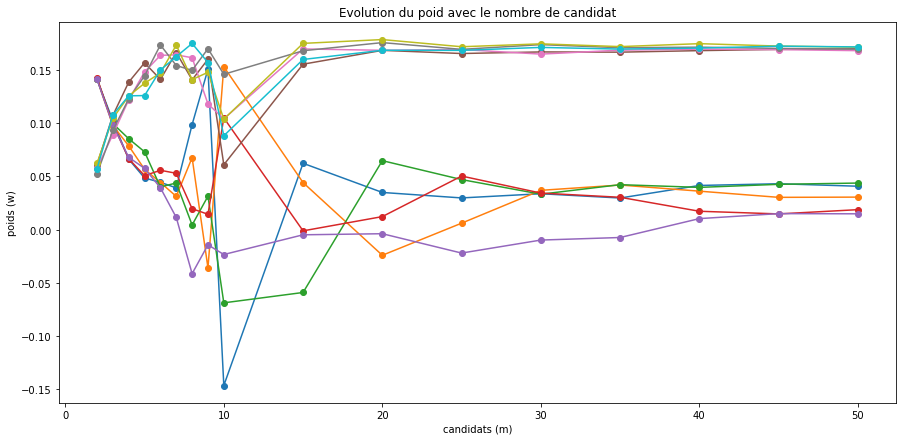

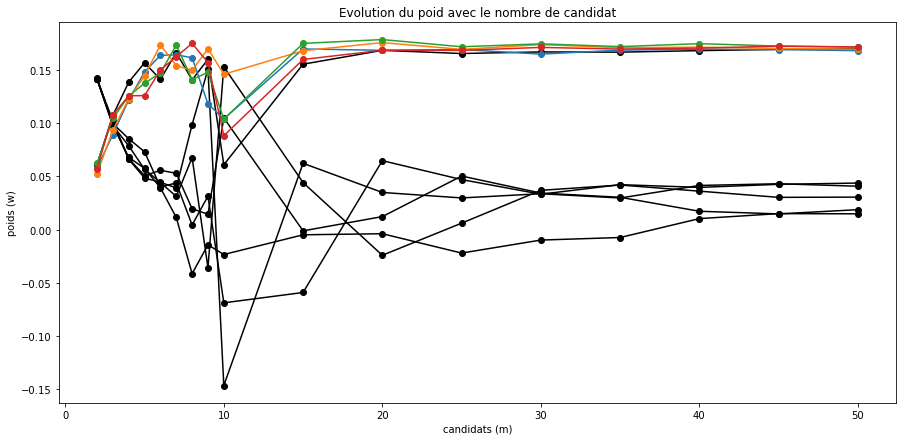

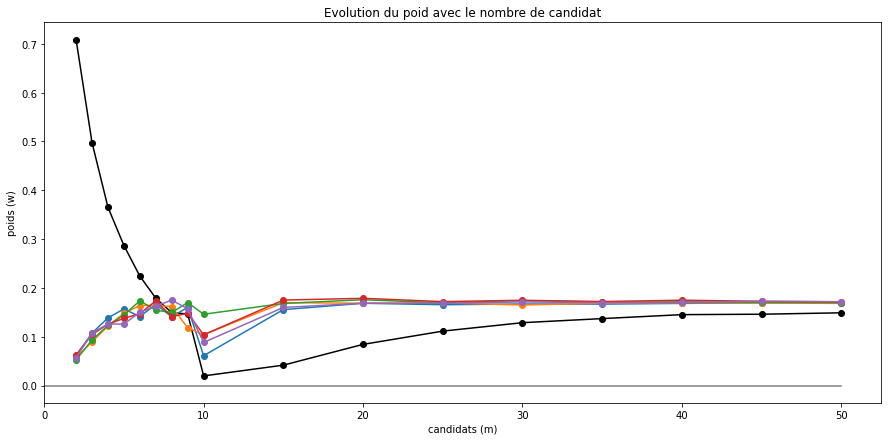

In [22]:

plt.figure(figsize=(15,7))
plt.plot(list_candidates,welf,"o-")
    
plt.show()

plt.figure(figsize=(15,7))
for i in range(n_voters):
    plt.plot(list_candidates,weights[:,i]/np.abs(weights).sum(1), 'o-')

plt.xlabel("candidats (m)")
plt.ylabel("poids (w)")
plt.title("Evolution du poid avec le nombre de candidat")
# plt.xlim(0,10)
plt.show()


plt.figure(figsize=(15,7))
for i in range(n_voters):
    if i <= 5:
        plt.plot(list_candidates,weights[:,i]/np.abs(weights).sum(1), 'o-', color='k')
    else:
        plt.plot(list_candidates,weights[:,i]/np.abs(weights).sum(1), 'o-')

plt.xlabel("candidats (m)")
plt.ylabel("poids (w)")
plt.title("Evolution du poid avec le nombre de candidat")
# plt.xlim(0,10)
plt.show()



plt.figure(figsize=(15,7))
tab = np.zeros((l_cand))
for i in range(5):
    tab += weights[:,i]/np.abs(weights).sum(1)
    
plt.plot(list_candidates, tab, 'o-', c='k')
for i in range(5,n_voters):
    plt.plot(list_candidates,weights[:,i]/np.abs(weights).sum(1), 'o-')
    
plt.plot([0,50],[0,0], "grey")

plt.xlabel("candidats (m)")
plt.ylabel("poids (w)")
plt.title("Evolution du poid avec le nombre de candidat")
plt.xlim(0)
# plt.xlim(0,10)
plt.show()

In [19]:
n_agg = len(list_agg)
list_candidates = [2,3,4] + list(np.arange(5,51,5))
l_cand = len(list_candidates)
max_candidates = 50
n_voters = 24
results_algo = np.zeros((l_cand))



for index_try in tqdm(range(n_trys)):
    
    for i in range(l_cand):
        n_candidates = list_candidates[i]
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_


        w = np.argmax(ratings_candidates[0])
        results_algo[i] += welfare[w]
            
results_algo/n_trys

 47%|████▋     | 4671/10000 [00:10<00:11, 466.33it/s]


KeyboardInterrupt: 

In [24]:
tab = [2,3,4] + [i*5 for i in range(1,11)]
for i in range(len(tab)):
    print(tab[i], (results_algo/n_trys)[i])

2 0.5764
3 0.608775939770273
4 0.6188116708739182
5 0.6222528494556046
10 0.6399266848394259
15 0.6492231455654601
20 0.654869210573013
25 0.6604193417713734
30 0.6639371423478481
35 0.6666235678136397
40 0.6702430307685925
45 0.6750097713442761
50 0.6788517311954338


In [20]:
n_agg = len(list_agg)
list_candidates = [2,3,4] + list(np.arange(5,51,5))
l_cand = len(list_candidates)
max_candidates = 50
n_voters = 10
results_exp = np.zeros((n_agg, l_cand))

training = ratings_training[26:26+n_voters]
_ = list_agg[-2](training).winner_
list_agg[-2].train()
_ = list_agg[-1](training).winner_
list_agg[-1].train()


for index_try in tqdm(range(n_trys)):
    
    for i in range(l_cand):
        n_candidates = list_candidates[i]
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[26:26+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]

        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_3 = results_exp

  0%|          | 1/10000 [00:00<16:41,  9.98it/s]C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 10000/10000 [17:31<00:00,  9.51it/s]


In [10]:
results_exp_3

array([[6659.        , 7589.39780727, 7844.62040344, 7820.34414759,
        6567.71929215, 7511.50878851, 8045.75520381, 8277.26688231,
        8377.90548037, 8473.16000767, 8536.71544904, 8572.57084729,
        8597.18889227]])

In [40]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 8))
for i in range(len(results_exp)):
    plt.plot(list_candidates, 
             results_exp[order_next[i]]/n_trys, 
             'o-', 
             label=rules_names[order_next[i]],
             color=colors[algos_name[order_next[i]]], 
             linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(2,50)
plt.xlabel("Number of candidates")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with number of candidates")
plt.legend()
plt.grid(0.3)
plt.show()

NameError: name 'order_next' is not defined

<Figure size 1440x576 with 0 Axes>

In [21]:
np.savetxt("results_expe_3_small3.csv", results_exp_3/n_trys, delimiter=",")

In [15]:
n_agg = len(list_agg)
list_candidates = [2,3,4] + list(np.arange(5,51,5))
l_cand = len(list_candidates)
max_candidates = 50
n_voters = 24
results_exp = np.zeros((2, l_cand))

for i in range(l_cand):
    n_candidates = list_candidates[i]
    
    algo_welfare = np.zeros(n_voters)
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, 2))]
    
    for index_try in tqdm(range(n_trys)):
        truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
        ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]

        for agg in list_agg:
            agg.reset()
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
            
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
    results_exp[1][i] = np.max(algo_welfare)

100%|██████████| 10000/10000 [00:29<00:00, 341.15it/s]


In [16]:
np.savetxt("results_expe_3_bounds.csv", results_exp/n_trys, delimiter=",")

# Groups noise

In [24]:
list_gnoises = list(np.arange(0,21,2))
l_gnoises = len(list_gnoises)
max_candidates = 50
n_voters = 24
n_candidates = 20
results_algo = np.zeros((l_gnoises))

for i in range(l_gnoises):
    noise = list_gnoises[i]
    
    if noise == 10:
        ratings_training = np.loadtxt("ratings_base_case_training_normal.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_base_case_testing_normal.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("ratings_gnoise_%i_training_normal.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_gnoise_%i_testing_normal.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == 10:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results


        w = np.argmax(ratings_candidates[0])
        results_algo[i] += welfare[w]
            


100%|██████████| 10000/10000 [00:01<00:00, 5664.72it/s]


In [32]:
for i in range(len(list_gnoises)):
    print(list_gnoises[i], (results_algo/n_trys)[i])

0 0.910746124377702
2 0.8683476714004779
4 0.7938131966226283
6 0.7356718440401965
8 0.6917552954598909
10 0.654869210573013
12 0.6336371975228282
14 0.6131733158481762
16 0.6028307065167292
18 0.5957334030420606
20 0.5838869227930436


In [26]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_gnoises = list(np.arange(0,21,2))
l_gnoises = len(list_gnoises)
max_candidates = 50
n_voters = 24
n_candidates = 20
results_exp = np.zeros((n_agg, l_gnoises))

for i in range(l_gnoises):
    noise = list_gnoises[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if noise == 10:
        ratings_training = np.loadtxt("ratings_base_case_training_normal.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_base_case_testing_normal.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("ratings_gnoise_%i_training_normal.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_gnoise_%i_testing_normal.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == 10:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_5 = results_exp

 71%|███████▏  | 7127/10000 [01:46<00:43, 66.73it/s]


KeyboardInterrupt: 

In [ ]:
np.savetxt("results_expe_5_normal.csv", results_exp_5/n_trys, delimiter=",")

In [19]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_gnoises = list(np.arange(0,21,2))
l_gnoises = len(list_gnoises)
max_candidates = 50
n_candidates = 20
n_voters = 24
results_exp = np.zeros((2, l_gnoises))

for i in range(l_gnoises):
    noise = list_gnoises[i]
    algo_welfare = np.zeros(n_voters)
    if noise == 10:
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_testing = np.loadtxt("data_paper/ratings_gnoise_%i_testing.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
    
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), noise, 2))]
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == 10:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
            
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
        
    results_exp[1][i] = np.max(algo_welfare)
            

100%|██████████| 10000/10000 [00:15<00:00, 643.29it/s]


In [20]:
np.savetxt("results_expe_5_bounds.csv", results_exp/n_trys, delimiter=",")

# Independent noise

In [ ]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_inoises = [0,1] + list(np.arange(2,21,2))
l_inoises = len(list_inoises)
max_candidates = 50
n_voters = 24
results_exp = np.zeros((n_agg, l_inoises))

for i in range(l_inoises):
    noise = list_inoises[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if noise == 2:
        ratings_training = np.loadtxt("data_paper/ratings_base_case_training_normal.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing_normal.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("data_paper/ratings_inoise_%i_training_normal.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_inoise_%i_testing_normal.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    print(i, len(list_inoises))
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == 2:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_6 = results_exp

In [35]:
list_inoises = [0,1] + list(np.arange(2,21,2))
l_inoises = len(list_inoises)
max_candidates = 50
n_voters = 24
results_algo = np.zeros((l_inoises))

for i in range(l_inoises):
    noise = list_inoises[i]
    
    if noise == 2:
        ratings_training = np.loadtxt("ratings_base_case_training_3.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_base_case_testing_3.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("ratings_inoise_%i_training.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_inoise_%i_testing.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
        

    for index_try in tqdm(range(n_trys)):
    
        if noise == 2:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
        
        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results


        w = np.argmax(ratings_candidates[0])
        results_algo[i] += welfare[w]
        

100%|██████████| 10000/10000 [00:01<00:00, 5799.16it/s]


In [36]:
for i in range(len(list_inoises)):
    print(list_inoises[i], (results_algo/n_trys)[i])

0 0.6567058607741034
1 0.6653441288329929
2 0.654869210573013
4 0.6471170973104495
6 0.6437489544088271
8 0.6237662714582557
10 0.617093207902351
12 0.605099710237619
14 0.595116811218917
16 0.585415784391639
18 0.5831264067967521
20 0.5826381124060238


In [ ]:
np.savetxt("results_expe_6_normal.csv", results_exp_6/n_trys, delimiter=",")

In [4]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_inoises = [0,1] + list(np.arange(2,21,2))
l_inoises = len(list_inoises)
max_candidates = 50
n_candidates = 20
n_voters = 24
results_exp = np.zeros((2, l_inoises))

for i in range(l_inoises):
    noise = list_inoises[i]
    algo_welfare = np.zeros(n_voters)
    if noise == 2:
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_testing = np.loadtxt("data_paper/ratings_inoise_%i_testing.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
    
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, noise))]
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == 2:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for agg in list_agg:
            agg.reset()
            
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
        

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
    results_exp[1][i] = np.max(algo_welfare)

100%|██████████| 10000/10000 [00:18<00:00, 544.58it/s]


In [6]:
np.savetxt("results_expe_6_bounds.csv", results_exp/n_trys, delimiter=",")

# Groupe noise function

In [8]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
print(n_agg)
list_gnoises = ["Normal", "GenNormLarge", "GenNormSmall", "SkewNormLeft", "SkewNormRight"]
l_gnoises = len(list_gnoises)
max_candidates = 50
n_voters = 24
results_exp = np.zeros((n_agg, l_gnoises))
n_candidates = 20

for i in range(l_gnoises):
    noise = list_gnoises[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if noise == "Normal":
        ratings_training = np.loadtxt("ratings_base_case_training_3.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_base_case_testing_3.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("ratings_noisef_%s_training.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_noisef_%s_testing.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    print(training.shape, ratings_testing.shape)
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == "Normal":
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_7 = results_exp

7
(24, 1000) (51, 500000)


100%|██████████| 10000/10000 [02:25<00:00, 68.50it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:29<00:00, 67.11it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:29<00:00, 66.77it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:33<00:00, 65.14it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:33<00:00, 65.19it/s]


In [9]:
np.savetxt("results_expe_7_1028.csv", results_exp_7/n_trys, delimiter=",")

# Indep noise function

In [60]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_gnoises = ["Normal", "GenNormLarge", "GenNormSmall", "SkewNormLeft", "SkewNormRight"]
l_gnoises = len(list_gnoises)
max_candidates = 50
n_voters = 24
n_candidates = 20
results_exp = np.zeros((n_agg, l_gnoises))

for i in range(l_gnoises):
    noise = list_gnoises[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if noise == "Normal":
        ratings_training = np.loadtxt("ratings_base_case_training_3.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_base_case_testing_3.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("ratings_inoisef_%s_training.csv"%noise,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("ratings_inoisef_%s_testing.csv"%noise,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    print(training.shape, ratings_testing.shape)
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if noise == "Normal":
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_8 = results_exp

(24, 1000) (51, 500000)


100%|██████████| 10000/10000 [02:28<00:00, 67.34it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:28<00:00, 67.16it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:26<00:00, 68.41it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:36<00:00, 64.07it/s]


(24, 1000) (25, 200000)


100%|██████████| 10000/10000 [02:36<00:00, 63.75it/s]


In [63]:
np.savetxt("results_expe_8_1024.csv", results_exp_8/n_trys, delimiter=",")

# Badly trained algos

In [34]:

list_agg = [ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), name="MLE-t", default_train=False, default_add=False),
            ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash-t", default_train=False,default_add=False)]

In [15]:
 np.random.permutation(np.array([[1,2,3],[4,5,6],[7,8,9]]))

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

In [16]:
ratings_training.shape

(25, 1000)

In [37]:
n_agg = len(list_agg)
n_voters = 24
results_exp = np.zeros((2, n_trys))
accuracy_exp = np.zeros((2, n_trys))

training = ratings_training[11:11+n_voters]
for i in range(50):
    training[:,i*20:(i+1)*20] = np.random.permutation(training[:,i*20:(i+1)*20])
    
_ = list_agg[-2](training).winner_
list_agg[-2].train()
_ = list_agg[-1](training).winner_
list_agg[-1].train()


for index_try in tqdm(range(n_trys)):
    truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
    ratings_candidates = ratings_testing[11:11+n_voters,max_candidates*index_try:max_candidates*index_try+n_candidates]
    i = 20

    ## training
    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
    # getting the results

    for k,agg in enumerate(list_agg):
        w = agg(ratings_candidates).winner_
        results_exp[k][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_exp[k][index_try] += 1
            


100%|██████████| 10000/10000 [00:26<00:00, 379.15it/s]


In [38]:
results_exp.mean(1)

array([0.65799917, 0.65683669])

In [39]:
np.savetxt("results_expe_base_badly_0921.csv", results_exp, delimiter=",")
np.savetxt("accuracy_expe_base_badly_0921.csv", accuracy_exp, delimiter=",")

# Cross Corell 1

In [41]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_alpha = [0.1*i for i in range(12)]
l_alpha = len(list_alpha)
max_candidates = 50
n_voters = 24
n_candidates = 20
results_exp = np.zeros((n_agg, l_alpha))
n_trys = 10000

for i in range(l_alpha):
    alpha = list_alpha[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if alpha == 1.1:
        ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("data_paper/ratings_cc1_%.2f_training.csv"%alpha,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_cc1_%.2f_testing.csv"%alpha,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if alpha == 1.1:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_10 = results_exp

100%|██████████| 10000/10000 [02:16<00:00, 73.08it/s]


In [42]:
np.savetxt("results_expe_10_0921.csv", results_exp_10/n_trys, delimiter=",")

In [ ]:
def mymatrix(alpha):
    M = np.eye(24)
    for i in range(20):
        M[i] = [alpha**(np.abs(j-i)) for j in range(20)]+[0]*4
    return M


n_agg = len(list_agg)
list_alpha = [0.1*i for i in range(12)]
l_alpha = len(list_alpha)
max_candidates = 50
n_candidates = 20
n_voters = 24
results_exp = np.zeros((3, l_alpha))


for i in range(l_alpha):
    alpha = list_alpha[i]
    algo_welfare = np.zeros(n_voters)
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, 2)),
               ev.Aggregator(rule=ev.RuleModelAware([1]*24, mymatrix(alpha), 10, 2))]
    
    if alpha == 1.1:
        ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("data_paper/ratings_cc1_%.2f_training.csv"%alpha,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_cc1_%.2f_testing.csv"%alpha,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    for index_try in tqdm(range(n_trys)):
    
        if alpha == 1.1:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for agg in list_agg:
            agg.reset()
            
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
        

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
    results_exp[2][i] = np.max(algo_welfare)

In [10]:
np.savetxt("results_expe_10_bounds.csv", results_exp/n_trys, delimiter=",")

In [20]:
ratings_training = np.loadtxt("data_paper/ratings_cc2_%.2f_training.csv"%1,dtype=float,delimiter=",")
ratings_testing = np.loadtxt("data_paper/ratings_cc2_%.2f_testing.csv"%1,dtype=float,delimiter=",")

In [23]:
ratings_testing.shape

(25, 500000)

In [43]:
#ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
#ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
n_agg = len(list_agg)
list_alpha = [0.1*i for i in range(11)]
l_alpha = len(list_alpha)
max_candidates = 50
n_voters = 24
n_candidates = 20
results_exp = np.zeros((n_agg, l_alpha))

n_trys = 10000
for i in range(l_alpha):
    alpha = list_alpha[i]
    for agg in list_agg[-2:]:
        agg.reset()
    
    if alpha == 0:
        ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("data_paper/ratings_cc2_%.2f_training.csv"%alpha,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_cc2_%.2f_testing.csv"%alpha,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    _ = list_agg[-2](training).winner_
    list_agg[-2].train()
    _ = list_agg[-1](training).winner_
    list_agg[-1].train()
    
    for index_try in tqdm(range(n_trys)):
    
        if alpha == 0:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg[:-2]:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
results_exp_11 = results_exp

100%|██████████| 10000/10000 [02:20<00:00, 71.03it/s]


In [44]:
np.savetxt("results_expe_11_0921.csv", results_exp_11/n_trys, delimiter=",")

In [49]:
def mymatrix(alpha):
    M = np.eye(5)
    for i in range(4):
        M[i+1,0] = alpha
        M[i+1,i+1] = 1-alpha
        
    return M

n_agg = len(list_agg)
list_alpha = [0.1*i for i in range(11)]
l_alpha = len(list_alpha)
max_candidates = 50
n_candidates = 20
n_voters = 24
results_exp = np.zeros((3, l_alpha))


for i in range(l_alpha):
    alpha = list_alpha[i]
    algo_welfare = np.zeros(n_voters)
    
    list_agg = [ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], np.eye(5), 10, 2)),
               ev.Aggregator(rule=ev.RuleModelAware([20,1,1,1,1], mymatrix(alpha), 10, 2))]
    
    if alpha == 0:
        ratings_training = np.loadtxt("data_paper/ratings_base_case_training.csv",dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_base_case_testing.csv",dtype=float,delimiter=",")
        training = ratings_training[11:35]
    else:
        ratings_training = np.loadtxt("data_paper/ratings_cc2_%.2f_training.csv"%alpha,dtype=float,delimiter=",")
        ratings_testing = np.loadtxt("data_paper/ratings_cc2_%.2f_testing.csv"%alpha,dtype=float,delimiter=",")
        training = ratings_training[1:]
        
    for index_try in tqdm(range(n_trys)):
    
        if alpha == 0:
            truth = ratings_testing[0,max_candidates*index_try:max_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[11:35,max_candidates*index_try:max_candidates*index_try+n_candidates]
        else:
            truth = ratings_testing[0,n_candidates*index_try:n_candidates*index_try+n_candidates]
            ratings_candidates = ratings_testing[1:,n_candidates*index_try:n_candidates*index_try+n_candidates]
            
        for agg in list_agg:
            agg.reset()

        ## training
        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for agg in list_agg:
            agg.reset()
            
        for j in range(len(ratings_candidates)):
            w = np.argsort(ratings_candidates[j])[-1]
            algo_welfare[j] += welfare[w]
        

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[k][i] += welfare[w]
            
    results_exp[2][i] = np.max(algo_welfare)

100%|██████████| 10000/10000 [00:29<00:00, 334.80it/s]


In [50]:
np.savetxt("results_expe_11_bounds.csv", results_exp/n_trys, delimiter=",")